# Probando RF sin tunear

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns', 50)


In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12.0,8.0]

In [3]:
df_train = pd.read_csv("../data/palabras.csv")

In [4]:
df_train['fecha'] = pd.to_datetime(df_train['fecha'], errors='coerce').astype(int) / 10**9

In [5]:
def fill_m2(df):
    df['metrostotales'].fillna(df['metroscubiertos'], inplace=True)
    df['metroscubiertos'].fillna(df['metrostotales'], inplace=True)
    
    return df

In [6]:
df_train

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,anio,mes,dia,palabra_hermosa,...,palabra_frente,palabra_vista,palabra_visitas,palabra_parque,palabra_areas,palabra_estrenar,palabra_infonavit,palabra_residencial,palabra_escuela,palabra_exclusivo,palabra_lujo,palabra_esquina,palabra_refaccion,palabra_country,palabra_barra,palabra_lavado,palabra_renta,palabra_super,palabra_lago,palabra_bosque,palabra_avenida,palabra_hospital,palabra_pileta,palabra_solarium,palabra_gas
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23533.0,1.440288e+09,0.0,0.0,0.0,0.0,0.0,2273000.0,2015,8,23,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,2.0,268.0,180.0,24514.0,1.372378e+09,0.0,0.0,0.0,1.0,1.0,3600000.0,2013,6,28,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,2.0,144.0,166.0,48551.0,1.445040e+09,0.0,0.0,0.0,0.0,0.0,1200000.0,2015,10,17,1,...,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,1.0,63.0,67.0,53666.0,1.331251e+09,0.0,0.0,0.0,1.0,1.0,650000.0,2012,3,9,0,...,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,1.0,95.0,95.0,47835.0,1.465258e+09,0.0,0.0,0.0,0.0,0.0,1150000.0,2016,6,7,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,119879,bonita casas de 2 recamaras a 10 minutos del c...,vendo casa en bosques de ica residencial a 10 ...,Casa,BOSQUES,Zinacantepec,Edo. de México,0.0,2.0,2.0,1.0,67.0,NaN,53666.0,1.423354e+09,0.0,0.0,0.0,0.0,0.0,650000.0,2015,2,8,1,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
239996,259178,casa en condominio a 10 min. del centro de toluca,"casa con un jardin amplio, un cuarto de servic...",Casa,Filiberto Navas 325,Toluca,Edo. de México,0.0,3.0,3.0,3.0,200.0,250.0,51954.0,1.404950e+09,0.0,0.0,0.0,1.0,1.0,1940000.0,2014,7,10,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
239997,131932,nicolas san juan,"departamento con excelente ubicación, muy cerc...",Apartamento,Nicolas San Juan,Benito Juárez,Distrito Federal,20.0,2.0,1.0,2.0,138.0,138.0,50003995.0,1.425341e+09,0.0,0.0,0.0,0.0,0.0,3400000.0,2015,3,3,0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
239998,146867,casa sola. javier rojo gomez.,"casa sola, dividida en cuatro departamentos de...",Casa,Javier Rojo Gomez 120,Iztapalapa,Distrito Federal,20.0,4.0,0.0,4.0,235.0,137.0,24162.0,1.419552e+09,1.0,0.0,0.0,1.0,1.0,2890000.0,2014,12,26,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


## Pre-processing

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [8]:
def getDropCols():
    return ['titulo', 'descripcion', 'direccion', 'id', 'dia', 'mes'] # temporal

def getOneHotCols():
    return ['tipodepropiedad', 'provincia']

def getBinaryCols():
    return ['ciudad', 'idzona']

In [9]:
def preprocess(df, OHE, BE, encodingType):
    features = df.copy()
    drop_cols = getDropCols()
    features = features.drop(drop_cols, axis=1)

    if (encodingType == 'train'):
        features = OHE.fit_transform(features)
        features = BE.fit_transform(features)
    else:
        features = OHE.transform(features)
        features = BE.transform(features)
        
    drop_cols = getOneHotCols()
    drop_cols.extend(getBinaryCols())

    display(drop_cols)
                
    #features = features.drop(drop_cols, axis=1)
    
    features = fill_m2(features)
    
    features_with_nans = features.columns[features.isna().any()].tolist()
    
    for feature in features_with_nans:
        features[feature] = features[feature].fillna(0)
        
    #imp = Imputer()
    #imp_cols = ['antiguedad', 'banos', 'habitaciones', 'garages']
    #X_train[imp_cols] = imp.fit_transform(X_train[imp_cols])
        
    return features    

In [10]:
import category_encoders as ce

OHE = ce.OneHotEncoder(cols=getOneHotCols(), handle_unknown='ignore', use_cat_names=True)
BE = ce.BinaryEncoder(cols=getBinaryCols(), handle_unknown='ignore')

In [11]:
X = df_train.drop("precio", axis=1)
y = df_train['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
X_train_submit = X_train.copy()

In [13]:
X_train = preprocess(X_train, OHE, BE, 'train')
X_test = preprocess(X_test, OHE, BE, 'test')

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

In [14]:
print(f"Original shapes: X={X.shape} y={y.shape}")
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 80) y=(240000,)
Train shapes: X=(180000, 154) y=(180000,)
Test  shapes: X=(60000, 154)  y=(60000,)


## Feature Selection

In [16]:
#from sklearn.feature_selection import SelectKBest

In [17]:
#selection = SelectKBest(k=40)
#x_features = selection.fit_transform(X_train, y_train)
#columns = np.asarray(X_train.columns.values)
#support = np.asarray(selection.get_support())
#columns_with_support = columns[support]

In [18]:
#columns_with_support

## Training

In [15]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000,n_jobs=3,objective="reg:squarederror",max_depth= 14, min_child_weight= 10,eval_metric="rmse")


In [16]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=14, min_child_weight=10, missing=None,
             n_estimators=1000, n_jobs=3, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [21]:
# Matriz de correlaciones como heatmap
#plt.figure(figsize=(15, 15))
#sns.heatmap(df_train.corr(), square=True, fmt='.2f');

## Predicciones

In [17]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.predict(test_features)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    
    if ~test_labels.empty:
        error = mean_absolute_error(test_labels, predict)
        score = model.score(test_features,test_labels)
        print('Testeo: {:0.4f}%.'.format(score*100))
        print('Mean abs error: {:0.4f}.'.format(error))
    
    return predict

In [18]:
predecir(model, X_train, y_train, X_test, y_test)

Entrenamiento: 99.8355%
Testeo: 82.4243%.
Mean abs error: 521418.9022.


array([3434009. , 2457585.8, 6280126. , ..., 1995870.6, 2299725.2,
       1282822.2], dtype=float32)

In [37]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_

d = {'x':X_train.columns,'y':importancia}

df_importancia = pd.DataFrame(d)

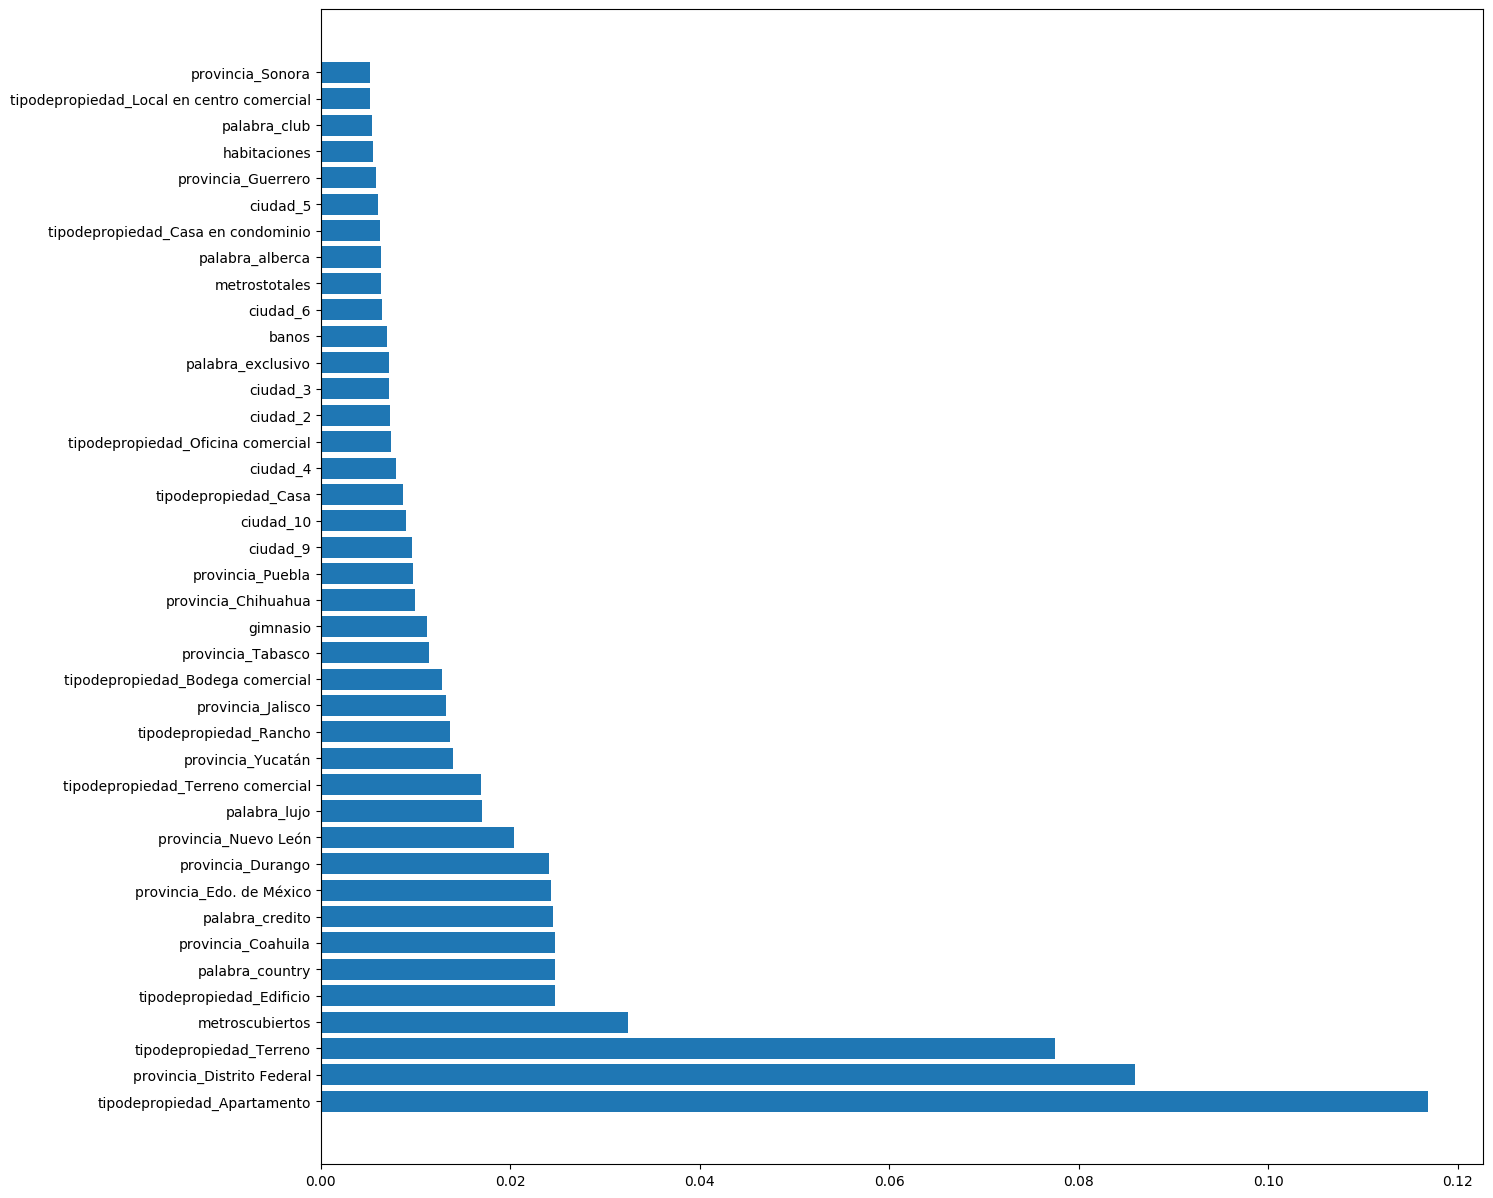

In [39]:
importancia = df_importancia.sort_values(by="y",ascending=False).head(40)
ax = plt.barh(importancia.x,importancia.y)

 ## Tunning

In [27]:
from sklearn.model_selection import GridSearchCV
param_test1 = {
 'n_estimators':range(100,1001,50)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(max_depth= 14,min_child_weight = 15,objective="reg:squarederror"), 
                        param_grid = param_test1,
                        n_jobs=3,
                        cv=3,
                        verbose=10)

gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  5.9min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 16.3min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 35.7min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 78.6min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 126.5min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 209.2min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 311.7min
[Parallel(n_jobs=3)]: Done  57 out of  57 | elapsed: 488.3min finished


({'n_estimators': 1000}, 0.8137251523359771)

In [28]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 1000}, 0.8137251523359771)

In [29]:
predecir(gsearch1,X_train,y_train,X_test,y_test)

Entrenamiento: 99.5766%
Testeo: 82.5467%.
Mean abs error: 522616.3517.


array([3354660.2, 2616176.8, 6249705.5, ..., 1489221.6, 2412194.8,
       1220648.9], dtype=float32)

## Submission

In [40]:
df_test = pd.read_csv('../data/test.csv')

In [41]:
df_test['fecha'] = pd.to_datetime(df_test['fecha'], errors='coerce')
df_test['anio'] = df_test['fecha'].dt.year
df_test["mes"] = df_test['fecha'].dt.month
df_test["dia"] = df_test['fecha'].dt.day
df_test['fecha'] = df_test['fecha'].astype(int) / 10**9

df_test = df_test.drop(columns=["lat","lng"])

df_test["descripcion"] = df_test["descripcion"].fillna("")
df_test["titulo"] = df_test["titulo"].fillna("")

In [42]:
def contiene(df, columna, palabra):
    return df[columna].str.contains(palabra).astype(int)

In [43]:
def contiene_alguna(df, columna, palabras):
    result = df[columna].apply(lambda x: 0)
    for palabra in palabras:
        result = result | contiene(df, columna, palabra)
        
    return result    

In [44]:
df = df_test.copy()

In [45]:
# del wordcloud
df["palabra_hermosa"] = contiene_alguna(df, "descripcion", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "preciosa", "precioso"]) | contiene_alguna(df, "titulo", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "precioso", "preciosa"])
df["palabra_excelente"] = contiene_alguna(df, "descripcion", ["excelente", "excelentes"]) | contiene_alguna(df, "titulo", ["excelente", "excelentes"])
df["palabra_mejor"] = contiene_alguna(df, "descripcion", ["mejor", "mejores"]) | contiene_alguna(df, "titulo", ["mejor", "mejores"])
df["palabra_grande"] = contiene_alguna(df, "descripcion", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"]) | contiene_alguna(df, "titulo", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"])
df["palabra_equipada"] = contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"]) | contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"])
df["palabra_vestidor"] = contiene_alguna(df, "descripcion", ["vestidor", "closet"]) | contiene_alguna(df, "titulo", ["vestidor", "closet"])
df["palabra_credito"] = contiene_alguna(df, "descripcion", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"]) | contiene_alguna(df, "titulo", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"])
df["palabra_privada"] = contiene_alguna(df, "descripcion", ["privada", "privado"]) | contiene_alguna(df, "titulo", ["privada", "privado"])
df["palabra_bodega"] = contiene_alguna(df, "descripcion", ["bodega"]) | contiene_alguna(df, "titulo", ["bodega"])
df["palabra_club"] = contiene_alguna(df, "descripcion", ["club"]) | contiene_alguna(df, "titulo", ["club"])
df["palabra_cerrada"] = contiene_alguna(df, "descripcion", ["cerrada", "cerrado"]) | contiene_alguna(df, "titulo", ["cerrada", "cerrado"])
df["palabra_jardin"] = contiene_alguna(df, "descripcion", ["jardin", "jardín", "garden", "patio"]) | contiene_alguna(df, "titulo", ["jardin", "jardín", "garden", "patio"])
df["palabra_oportunidad"] = contiene_alguna(df, "descripcion", ["oportunidad"]) | contiene_alguna(df, "titulo", ["oportunidad"])
df["palabra_tv"] = contiene_alguna(df, "descripcion", ["tv", "tele", "television", "televisión", "televisor"]) | contiene_alguna(df, "titulo", ["tv", "tele", "television", "televisión", "televisor"])
df["palabra_juegos"] = contiene_alguna(df, "descripcion", ["juego"]) | contiene_alguna(df, "titulo", ["juego"])
df["palabra_niño"] = contiene_alguna(df, "descripcion", ["niño", "niña", "infantil"]) | contiene_alguna(df, "titulo", ["niño", "niña", "infantil"])
df["palabra_transporte"] = contiene_alguna(df, "descripcion", ["transporte"]) | contiene_alguna(df, "titulo", ["transporte"])
df["palabra_estudio"] = contiene_alguna(df, "descripcion", ["estudio"]) | contiene_alguna(df, "titulo", ["estudio"])
df["palabra_terraza"] = contiene_alguna(df, "descripcion", ["terraza"]) | contiene_alguna(df, "titulo", ["terraza"])
df["palabra_balcon"] = contiene_alguna(df, "descripcion", ["balcón", "balcon"]) | contiene_alguna(df, "titulo", ["balcón", "balcon"])
df["palabra_lote"] = contiene_alguna(df, "descripcion", ["lote", "terreno"]) | contiene_alguna(df, "titulo", ["lote", "terreno"])
df["palabra_fraccionamiento"] = contiene_alguna(df, "descripcion", ["fraccionamiento", "fracc"]) | contiene_alguna(df, "titulo", ["fraccionamiento", "fracc"])
df["palabra_local"] = contiene_alguna(df, "descripcion", ["local", "tienda", "comercial"]) | contiene_alguna(df, "titulo", ["local", "tienda", "comercial"])
df["palabra_seguridad"] = contiene_alguna(df, "descripcion", ["vigilancia", "vigilador", "seguridad", "guardia"]) | contiene_alguna(df, "titulo", ["vigilancia", "vigilador", "seguridad", "guardia"])
df["palabra_garage"] = contiene_alguna(df, "descripcion", ["garage", "auto", "estacionamiento"]) | contiene_alguna(df, "titulo", ["garage", "auto", "estacionamiento"])
df["palabra_centro"] = contiene_alguna(df, "descripcion", ["centro", "central", "cercano", "cercania", "minuto"]) | contiene_alguna(df, "titulo", ["centro", "central", "cercano", "cercania", "minuto"])
df["palabra_techada"] = contiene_alguna(df, "descripcion", ["techada", "techado", "roof"]) | contiene_alguna(df, "titulo", ["techada", "techado", "roof"])
df["palabra_estancia"] = contiene_alguna(df, "descripcion", ["estancia"]) | contiene_alguna(df, "titulo", ["estancia"])
df["palabra_alberca"] = contiene_alguna(df, "descripcion", ["alberca"]) | contiene_alguna(df, "titulo", ["alberca"])
df["palabra_servicios"] = contiene_alguna(df, "descripcion", ["servicios"]) | contiene_alguna(df, "titulo", ["servicios"])
df["palabra_servicio"] = contiene_alguna(df, "descripcion", ["servicio"]) | contiene_alguna(df, "titulo", ["servicio"])
df["palabra_estilo"] = contiene_alguna(df, "descripcion", ["estilo"]) | contiene_alguna(df, "titulo", ["estilo"])
df["palabra_frente"] = contiene_alguna(df, "descripcion", ["frente"]) | contiene_alguna(df, "titulo", ["frente"])
df["palabra_vista"] = contiene_alguna(df, "descripcion", ["vista"]) | contiene_alguna(df, "titulo", ["vista"])
df["palabra_visitas"] = contiene_alguna(df, "descripcion", ["visita"]) | contiene_alguna(df, "titulo", ["visita"])
df["palabra_parque"] = contiene_alguna(df, "descripcion", ["parque", "plaza", "verde"]) | contiene_alguna(df, "titulo", ["parque", "plaza", "verde"])
df["palabra_areas"] = contiene_alguna(df, "descripcion", ["area", "área"]) | contiene_alguna(df, "titulo", ["area", "área"])
df["palabra_estrenar"] = contiene_alguna(df, "descripcion", ["estrenar", "estreno", "estrene"]) | contiene_alguna(df, "titulo", ["estrenar", "estreno", "estrene"])
df["palabra_infonavit"] = contiene_alguna(df, "descripcion", ["infonavit"]) | contiene_alguna(df, "titulo", ["infonavit"])
df["palabra_residencial"] = contiene_alguna(df, "descripcion", ["residencia"]) | contiene_alguna(df, "titulo", ["residencia"])
df["palabra_escuela"] = contiene_alguna(df, "descripcion", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"]) | contiene_alguna(df, "titulo", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"])
df["palabra_exclusivo"] = contiene_alguna(df, "descripcion", ["exclusivo", "exclusividad"]) | contiene_alguna(df, "titulo", ["exclusivo", "exclusividad"])
df["palabra_lujo"] = contiene_alguna(df, "descripcion", ["lujo"]) | contiene_alguna(df, "titulo", ["lujo"])
df["palabra_esquina"] = contiene_alguna(df, "descripcion", ["esquina"]) | contiene_alguna(df, "titulo", ["esquina"])
df["palabra_refaccion"] = contiene_alguna(df, "descripcion", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"]) | contiene_alguna(df, "titulo", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"])
df["palabra_country"] = contiene_alguna(df, "descripcion", ["country"]) | contiene_alguna(df, "titulo", ["country"])
df["palabra_barra"] = contiene_alguna(df, "descripcion", ["barra"]) | contiene_alguna(df, "titulo", ["barra"])
df["palabra_lavado"] = contiene_alguna(df, "descripcion", ["lavado"]) | contiene_alguna(df, "titulo", ["lavado"])
df["palabra_renta"] = contiene_alguna(df, "descripcion", ["renta", "alquiler", "alquilar"]) | contiene_alguna(df, "titulo", ["renta", "alquiler", "alquilar"])
df["palabra_super"] = contiene_alguna(df, "descripcion", ["super"]) | contiene_alguna(df, "titulo", ["super"])
df["palabra_lago"] = contiene_alguna(df, "descripcion", ["lago"]) | contiene_alguna(df, "titulo", ["lago"])
df["palabra_bosque"] = contiene_alguna(df, "descripcion", ["bosque", "arbol", "árbol"]) | contiene_alguna(df, "titulo", ["bosque", "arbol", "árbol"])
df["palabra_avenida"] = contiene_alguna(df, "descripcion", ["av", "avenida"]) | contiene_alguna(df, "titulo", ["av", "avenida"])
df["palabra_hospital"] = contiene_alguna(df, "descripcion", ["hospital", "medicina", "medico", "médico", "farmacia"]) | contiene_alguna(df, "titulo", ["hospital", "medicina", "medico", "médico", "farmacia"])
df["palabra_pileta"] = contiene_alguna(df, "descripcion", ["pileta", "piscina", "jacuzzi"]) | contiene_alguna(df, "titulo", ["pileta", "piscina", "jacuzzi"])
df["palabra_solarium"] = contiene_alguna(df, "descripcion", ["solarium"]) | contiene_alguna(df, "titulo", ["solarium"])
df["palabra_gas"] = contiene_alguna(df, "descripcion", ["gas", "estufa"]) | contiene_alguna(df, "titulo", ["gas", "estufa"])




In [46]:
print(f"Train shapes: X={X_train_submit.shape} y={y_train.shape}")
print(f"Test  shapes: X={df.shape}  ")

Train shapes: X=(180000, 80) y=(180000,)
Test  shapes: X=(60000, 80)  


In [47]:
#X_train_submit = preprocess(X_train_submit, OHE, BE, 'train')
df = preprocess(df, OHE, BE, 'test')

['tipodepropiedad', 'provincia', 'ciudad', 'idzona']

In [48]:
print(f"Train shapes: X={X_train_submit.shape} y={y.shape}")
print(f"Test  shapes: X={df.shape}")

Train shapes: X=(180000, 80) y=(240000,)
Test  shapes: X=(60000, 154)


In [49]:
submit_prediction = model.predict( df )

In [42]:
#cols_diff = []
#ft = X_train.columns.values
#fs = df.columns.values
#for feat in fs:
#    if feat not in ft:
#        cols_diff.append(feat)
        
#display(cols_diff)        

In [43]:
#pd.concat([df_test[['id']], pd.Series(submit_prediction)], axis=1).rename(columns={0:"target"}).to_csv("../data/submission13.csv", index=False)

In [51]:
from submission_helper import submission_output

output = submission_output(df_test, submit_prediction)

output.to_csv('../data/results/18-XGB.csv', index=False)